# Preprocessing


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [25]:
import re
import numpy as np
import pandas as pd
import tensorflow as tf
import nltk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

In [26]:
# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fajar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fajar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\fajar\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [27]:
data = pd.read_csv("D:/Kuliah/Semester 8/Portfolio/NLP/dataset_penyisihan_bdc_2024.csv", delimiter=";")

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5000 non-null   object
 1   label   5000 non-null   object
dtypes: object(2)
memory usage: 78.2+ KB


In [29]:
data.head()

,text,label
0,Kunjungan Prabowo ini untuk meresmikan dan men...,Sumber Daya Alam
1,RT Anies dapat tepuk tangan meriah saat jadi R...,Politik
2,@CIqXqwGAT04tMtx4OCATxjoVq7vv/Y8HeYaIOgMFg8Y= ...,Demografi
3,RT @L3R8XFBw3WGbxRPSj0/0hHZTbqVGX7qtfwRg9zmhK7...,Politik
4,Anies Baswedan Harap ASN termasuk TNI dan Polr...,Politik


In [30]:
print(data['label'].unique())
print(data.label.value_counts())

['Sumber Daya Alam' 'Politik' 'Demografi' 'Pertahanan dan Keamanan'
 'Ideologi' 'Ekonomi' 'Sosial Budaya' 'Geografi']
Politik                    2972
Sosial Budaya               587
Pertahanan dan Keamanan     400
Ideologi                    400
Ekonomi                     367
Sumber Daya Alam            192
Demografi                    62
Geografi                     20
Name: label, dtype: int64


### Stopword dan Lematisasi

In [31]:
# Initialize Sastrawi Stemmer and Stopword Remover
stemmer = StemmerFactory().create_stemmer()
stopwords = set(StopWordRemoverFactory().get_stop_words())

### Cleaning

In [ ]:
# Text Cleaning Function
def clean_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r'http\S+', '', text)  # hapus URL
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # hapus karakter non-alfanumerik
    text = re.sub(r'\s+', ' ', text).strip()  # hapus spasi berlebih
    words = text.split()  # tokenisasi manual
    # hapus stopword dan stemming
    words = [stemmer.stem(word) for word in words if word not in stopwords]
    return ' '.join(words)

data['clean_text'] = data['text'].apply(clean_text)

In [33]:
def is_noise_word(word):
    # Buang kata panjang yang tidak natural
    if len(word) > 20:
        return True

    # Terlalu banyak konsonan berturut-turut
    if re.search(r'[bcdfghjklmnpqrstvwxyz]{5,}', word):
        return True

    # Rasio vokal sangat rendah (< 20%)
    num_vowel = len(re.findall(r'[aeiou]', word))
    if len(word) > 8 and (num_vowel / len(word)) < 0.2:
        return True

    # Campuran huruf dan angka (terlihat seperti hash/id)
    if re.search(r'[a-zA-Z]', word) and re.search(r'\d', word):
        return True

    return False

def remove_noise_words(text):
    
    words = text.split()
    clean_words = [
        word for word in words
        if not is_noise_word(word) and not word.isdigit()
    ]
    return ' '.join(clean_words)

data['clean_text'] = data['clean_text'].apply(remove_noise_words)

In [34]:
data.head()

,text,label,clean_text
0,Kunjungan Prabowo ini untuk meresmikan dan men...,Sumber Daya Alam,kunjung prabowo resmi serah proyek bantu air b...
1,RT Anies dapat tepuk tangan meriah saat jadi R...,Politik,rt anies tepuk tangan riah jadi rektor wajib m...
2,@CIqXqwGAT04tMtx4OCATxjoVq7vv/Y8HeYaIOgMFg8Y= ...,Demografi,emng bener sih dukung yg goblok jg dg dukung h...
3,RT @L3R8XFBw3WGbxRPSj0/0hHZTbqVGX7qtfwRg9zmhK7...,Politik,rt waktu anies sikap kritis kerja pak prabowo ...
4,Anies Baswedan Harap ASN termasuk TNI dan Polr...,Politik,anies baswedan harap asn masuk tni polri pegan...


In [49]:
import pickle

# Buat dictionary berisi semua objek
text_processing_objects = {
    "stemmer": stemmer,
    "stopwords": stopwords,
    "clean_text": clean_text,
    "is_noise_word": is_noise_word,
    "remove_noise_words": remove_noise_words
}

# Simpan ke .pkl
with open("text_processing.pkl", "wb") as f:
    pickle.dump(text_processing_objects, f)

In [35]:
data.to_csv('data/prepData1.csv', index=False)

# MODEL

In [53]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import pickle

dataModel = pd.read_csv("data/prepData1.csv", delimiter=',')

In [54]:
dataModel.isna().sum()

text          0
label         0
clean_text    9
dtype: int64

In [55]:
dataModel = dataModel.dropna(subset=['clean_text'])

### Random Over Sampling

In [56]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(dataModel[['clean_text']], dataModel['label'])

### Padding and Tokenizing

In [57]:
# Tokenizer tanpa limit num_words (agar sesuai dengan FastText vocab)
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X_resampled['clean_text'])

MAX_LEN = 100
sequences = tokenizer.texts_to_sequences(X_resampled['clean_text'])
padded_sequences = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')

### Label Encode

In [58]:
# Encode label
le = LabelEncoder()
encoded_labels = le.fit_transform(y_resampled)
n_classes = len(le.classes_)

In [59]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, encoded_labels,
    test_size=0.2,
    stratify=encoded_labels,
    random_state=42
)

# One-hot encoding untuk output
y_train = tf.keras.utils.to_categorical(y_train, num_classes=n_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=n_classes)

### Pretrain FastText Bahasa

In [60]:
# ! pip install fasttext-wheel

In [61]:
import numpy as np
import fasttext

ft = fasttext.load_model('data/cc.id.300.bin')

EMBEDDING_DIM = 300
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

for word, i in word_index.items():
    embedding_matrix[i] = ft.get_word_vector(word)


In [69]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

embedding_layer = tf.keras.layers.Embedding(
    input_dim=len(word_index) + 1,
    output_dim=EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_LEN,
    trainable=False
)

lstm_model = tf.keras.models.Sequential([
    embedding_layer,
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01))),
    tf.keras.layers.Dropout(0.7),
    
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, kernel_regularizer=l2(0.01))),
    tf.keras.layers.Dropout(0.7),
    
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.7),
    
    tf.keras.layers.Dense(n_classes, activation='softmax'),
])

# Learning rate scheduling
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3, decay_steps=1000, decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

lstm_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = lstm_model.fit(X_train, y_train,
                    epochs=15,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks = [early_stop])

Epoch 1/15
475/475 [==============================] - 80s 157ms/step - loss: 2.7343 - accuracy: 0.2399 - val_loss: 1.7456 - val_accuracy: 0.3678
Epoch 2/15
475/475 [==============================] - 75s 158ms/step - loss: 1.6871 - accuracy: 0.3812 - val_loss: 1.5358 - val_accuracy: 0.4483
Epoch 3/15
475/475 [==============================] - 76s 159ms/step - loss: 1.5297 - accuracy: 0.4885 - val_loss: 1.3936 - val_accuracy: 0.5567
Epoch 4/15
475/475 [==============================] - 77s 162ms/step - loss: 1.3481 - accuracy: 0.5668 - val_loss: 1.1535 - val_accuracy: 0.6204
Epoch 5/15
475/475 [==============================] - 77s 162ms/step - loss: 1.2529 - accuracy: 0.6009 - val_loss: 1.1635 - val_accuracy: 0.6388
Epoch 6/15
475/475 [==============================] - 77s 161ms/step - loss: 1.2184 - accuracy: 0.6248 - val_loss: 1.0669 - val_accuracy: 0.6796
Epoch 7/15
475/475 [==============================] - 77s 162ms/step - loss: 1.1165 - accuracy: 0.6568 - val_loss: 0.9737 - val_ac

In [63]:
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 300)          3042900   
                                                                 
 bidirectional_2 (Bidirecti  (None, 100, 256)          439296    
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 100, 256)          0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)              

## Evaluasi

In [64]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [65]:
# Prediksi kelas (dalam bentuk indeks)
y_pred_probs = lstm_model.predict(padded_sequences)  # prediksi probabilitas
y_pred = np.argmax(y_pred_probs, axis=1)        # ambil indeks probabilitas tertinggi

# Konversi label asli (jika sebelumnya one-hot encoded)
y_true = encoded_labels


743/743 [==============================] - 45s 59ms/step


In [66]:
# Akurasi keseluruhan
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.4f}")

# Mean Squared Error (MSE)
mse = mean_squared_error(y_true, y_pred)
print(f"MSE (Mean Squared Error): {mse:.4f}")

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)
print(f"MAE (Mean Absolute Error): {mae:.4f}")

# Classification report: precision, recall, f1-score per kelas
target_names = le.classes_  # nama label asli
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))


Accuracy: 0.8439
MSE (Mean Squared Error): 1.4444
RMSE (Root Mean Squared Error): 1.2018
MAE (Mean Absolute Error): 0.3980

Classification Report:
                         precision    recall  f1-score   support

              Demografi       0.92      0.96      0.94      2969
                Ekonomi       0.90      0.85      0.87      2969
               Geografi       0.97      1.00      0.98      2969
               Ideologi       0.82      0.80      0.81      2969
Pertahanan dan Keamanan       0.90      0.89      0.89      2969
                Politik       0.59      0.50      0.54      2969
          Sosial Budaya       0.76      0.82      0.78      2969
       Sumber Daya Alam       0.87      0.93      0.90      2969

               accuracy                           0.84     23752
              macro avg       0.84      0.84      0.84     23752
           weighted avg       0.84      0.84      0.84     23752



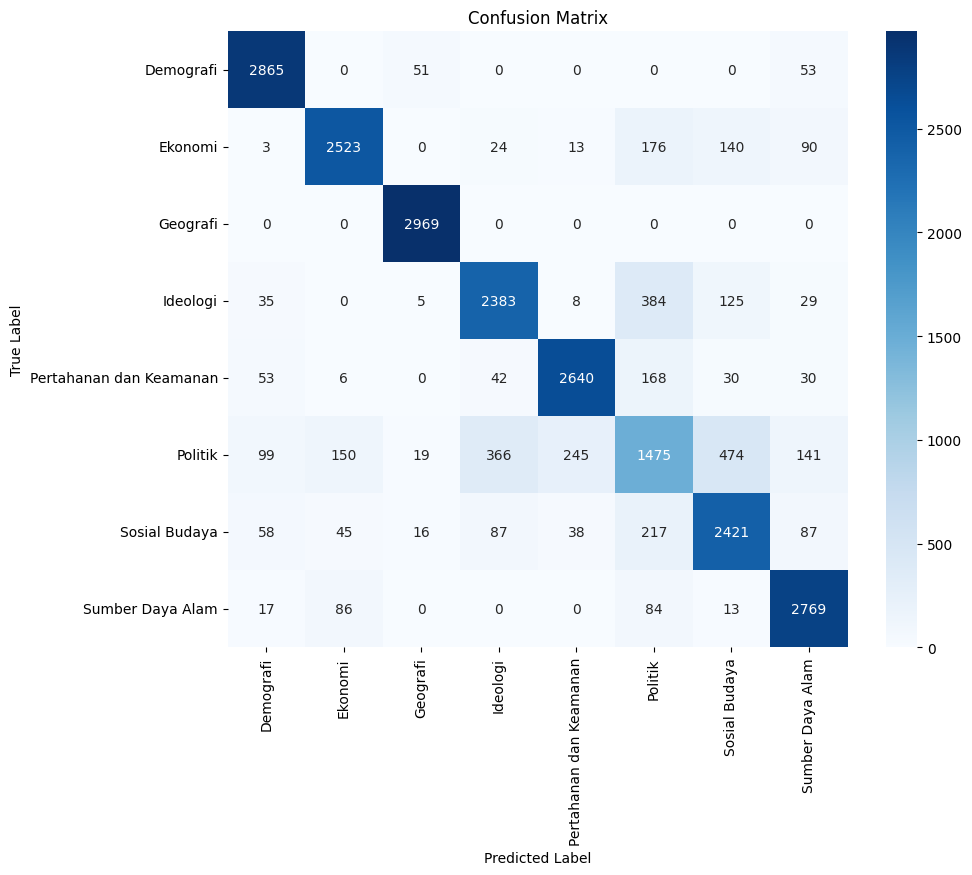

In [67]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# TESTING

In [52]:
# Load dan Preprocess Data Test
test_df = pd.read_csv("data/dataset_unlabeled_penyisihan_bdc_2024.csv", delimiter=";")


# Load objek preprocessing
with open("text_processing.pkl", "rb") as f:
    loaded_objects = pickle.load(f)

clean_text = loaded_objects["clean_text"]
remove_noise_words = loaded_objects["remove_noise_words"]
stemmer = loaded_objects["stemmer"]
stopwords = loaded_objects["stopwords"]


# Terapkan preprocessing
test_df['clean_text'] = test_df['Text'].apply(clean_text)
test_df['clean_text'] = test_df['clean_text'].apply(remove_noise_words)

# Konversi teks ke sequence
test_sequences = tokenizer.texts_to_sequences(test_df['clean_text'])
test_padded = pad_sequences(test_sequences, maxlen=MAX_LEN, padding='post', truncating='post')

# Prediksi label
lstm_predictions = np.argmax(lstm_model.predict(test_padded), axis=1)
test_df['lstm_predicted_label'] = le.inverse_transform(lstm_predictions)

# Simpan hasil
# test_df.to_csv("predicted_labels_unlabeled.csv", index=False)

# print("✅ Preprocessing dan prediksi selesai. Hasil disimpan di predicted_labels_unlabeled.csv")


# print("✅ Prediksi selesai. Hasil disimpan di predicted_labels_test.csv")


# Calculate Evaluation Metrics
y_true = encoded_labels[:len(test_df)]  # gunakan label sebenarnya untuk data test

print("LSTM Model Evaluation:")
print(classification_report(y_true, lstm_predictions))
print("MAE:", mean_absolute_error(y_true, lstm_predictions))
print("MSE:", mean_squared_error(y_true, lstm_predictions))
print("RMSE:", np.sqrt(mean_squared_error(y_true, lstm_predictions)))


# Save predictions
# unlabeled_df.to_csv("predicted_labels.csv", index=False)

AttributeError: Can't get attribute 'clean_text' on <module '__main__'>